In [1]:
import numpy as np
from numpy import random as rd
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.fftpack import fft
from scipy.fftpack import fftfreq
import pandas as pd
from decimal import Decimal, ROUND_HALF_UP
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
fname = '/Users/shohei/Desktop/Shohei/Fresnel/Detector/Paper'

In [3]:
# 各惑星系におけるパラメータ及び必要な測光制度
z = np.load('{}/Data/parameter_3000.npy'.format(fname))
R_star = np.load('{}/Data/radius.npy'.format(fname))*6.95508*10**10
R_planet = R_planet = 6.378137*10**8
p = R_planet/R_star
lamb = np.load('{}/Data/lamb.npy'.format(fname))
eh = 30*10**5
h = 6.62607004*10**(-27)
c = 2.9979245800*10**10
k = 1.38064852*10**(-16)
T_star = [2500, 3000, 3500, 4000]
T_planet = 288.2
accuracy = np.array([(np.exp(h*c/(lamb*10**(-4))/k/T_star[T])-1)/(np.exp(h*c/(lamb*10**(-4))/k/T_planet)-1)*(R_planet/R_star[T])**2
                     for T in range(4)])*10**6

# データの取得

In [4]:
df_spectrum = pd.read_csv('{}/Data/secondary_spectra.csv'.format(fname))

In [5]:
lamb_20 = np.load('{}/Data/lamb_20.npy'.format(fname))

In [6]:
wog_eva = np.load('{}/Simulation/Secondary/wog_evaluation_secondary.npy'.format(fname))
wog_sig = np.load('{}/Simulation/Secondary/wog_sigma_secondary.npy'.format(fname))
sci_eva = np.load('{}/Simulation/Secondary/sci_evaluation_secondary.npy'.format(fname))
sci_sig = np.load('{}/Simulation/Secondary/sci_sigma_secondary.npy'.format(fname))
sub_eva = np.load('{}/Simulation/Secondary/sub_evaluation_secondary.npy'.format(fname))
sub_sig = np.load('{}/Simulation/Secondary/sub_sigma_secondary.npy'.format(fname))

In [7]:
def binning(data, R):
    i = int(100/R)
    new_data = np.array([[[0]*(int(len(lamb)/i)+1)]*4]*100, float)
    for ll in range(int(len(lamb)/i)+1):
        n = 0
        for jj in range(i):
            if len(lamb)<=ll*i+jj:
                break
            new_data[:, :, ll] += data[:, :, ll*i+jj]
            n += 1
        new_data[:, :, ll] /= n
    return new_data

In [8]:
wog_eva_20 = binning(wog_eva, 20)
wog_sig_20 = binning(wog_sig, 20)
sci_eva_20 = binning(sci_eva, 20)
sci_sig_20 = binning(sci_sig, 20)
sub_eva_20 = binning(sub_eva, 20)
sub_sig_20 = binning(sub_sig, 20)

# データの修正

In [9]:
def Gauss(eva, sig, num):
    # systematic errorの平均値と分散値でガウス分布する値を作成
    eva_mean = np.mean(eva, axis=0)
    eva_std = np.std(eva, axis=0)
    systematic = rd.normal(eva_mean, eva_std)

    # random noiseの平均値と分散値でガウス分布する値を作成
    sig_mean = np.mean(sig, axis=0)
    sig_std = np.std(sig, axis=0)
    random = rd.normal(sig_mean, sig_std)
    
    return systematic, random

In [10]:
wog_sys, wog_rand = Gauss(wog_eva, wog_sig, len(wog_eva))
sci_sys, sci_rand = Gauss(sci_eva, sci_sig, len(sci_eva))
sub_sys, sub_rand = Gauss(sub_eva, sub_sig, len(sub_eva))

In [11]:
wog_sys_20, wog_rand_20 = Gauss(wog_eva_20, wog_sig_20, len(wog_eva_20))
sci_sys_20, sci_rand_20 = Gauss(sci_eva_20, sci_sig_20, len(sci_eva_20))
sub_sys_20, sub_rand_20 = Gauss(sub_eva_20, sub_sig_20, len(sub_eva_20))

In [12]:
wog_eva_std = np.std(wog_eva, axis=0)
sci_eva_std = np.std(sci_eva, axis=0)
sub_eva_std = np.std(sub_eva, axis=0)

In [13]:
wog_eva_std_20 = np.std(wog_eva_20, axis=0)
sci_eva_std_20 = np.std(sci_eva_20, axis=0)
sub_eva_std_20 = np.std(sub_eva_20, axis=0)

In [14]:
# R=100とR=20におけるspectrumを作成
spectra_secondary = np.array([df_spectrum[temp].values for temp in ['2500K', '3000K', '3500K', '4000K']])*10**6
func = [interpolate.interp1d(df_spectrum.wavelength.values, spectra_secondary[T], kind='cubic') for T in range(4)]
spectrum = [func[T](lamb) for T in range(4)]
spectrum_20 = [func[T](lamb_20) for T in range(4)]

# グラフ化

In [16]:
# 系統誤差とランダム誤差を示す図を作成
def Evaluation(i, x, y_wog_eva, y_wog_rand, y_sci_eva, y_sci_rand, y_sub_eva, y_sub_rand, T, ylim_min, ylim_max):
    plt.subplot(i)
    #plt.plot(x, abs(y_wog_eva[T]), 'ro', c='g', markersize=3.0)
    plt.plot(x, abs(y_sci_eva[T]), 'ro', c='r', markersize=3.0)
    plt.plot(x, abs(y_sub_eva[T]), 'ro', c='b', markersize=3.0)
    plt.plot(x, abs(y_wog_rand[T]), 'x', c='r', markersize=5.0)
    #plt.plot(x, abs(y_sci_rand[T]), 'x', c='r', markersize=5.0)
    plt.plot(x, abs(y_sub_rand[T]), 'x', c='b', markersize=5.0)
    plt.xlabel('Wavelength [μm]')
    plt.ylabel('ppm')
    plt.xlim(5, 20)
    plt.ylim(ylim_min, ylim_max)

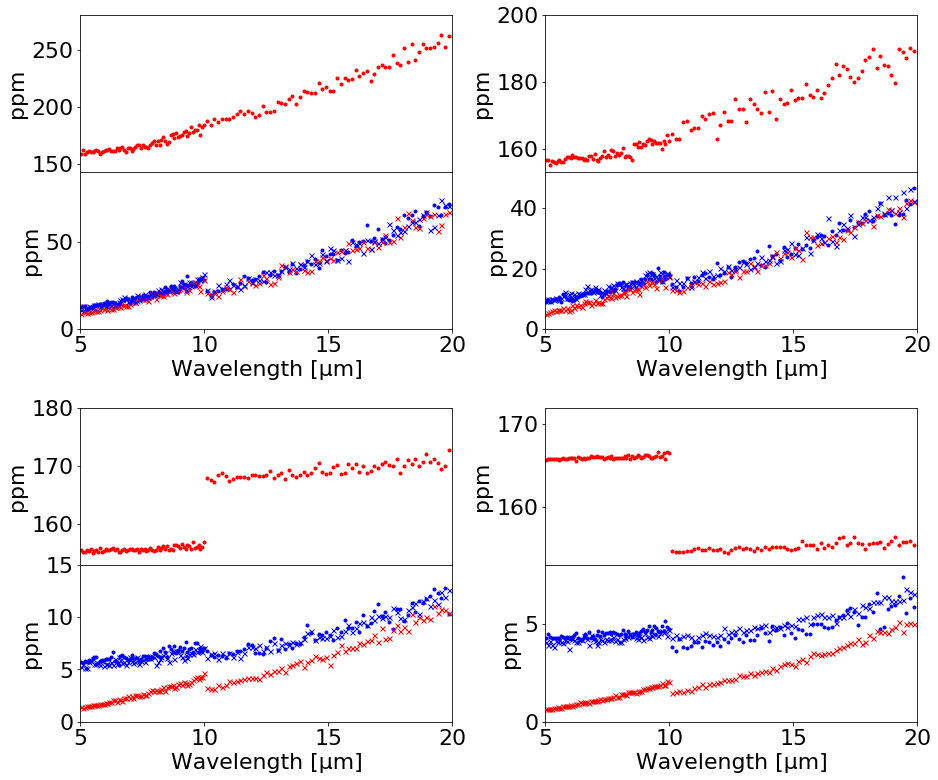

In [21]:
plt.figure(figsize=(15, 13))
gs = gridspec.GridSpec(9, 2)
plt.rcParams['font.size'] = 22
Evaluation(gs[0:2, 0], lamb, wog_eva_std, wog_rand, sci_eva_std, sci_rand, sub_eva_std, sub_rand, 0, 143, 280)
plt.xticks([])
Evaluation(gs[2:4, 0], lamb, wog_eva_std, wog_rand, sci_eva_std, sci_rand, sub_eva_std, sub_rand, 0, 0, 90)
Evaluation(gs[0:2, 1], lamb, wog_eva_std, wog_rand, sci_eva_std, sci_rand, sub_eva_std, sub_rand, 1, 153, 200)
plt.xticks([])
Evaluation(gs[2:4, 1], lamb, wog_eva_std, wog_rand, sci_eva_std, sci_rand, sub_eva_std, sub_rand, 1, 0, 52)
Evaluation(gs[5:7, 0], lamb, wog_eva_std, wog_rand, sci_eva_std, sci_rand, sub_eva_std, sub_rand, 2, 153, 180)
plt.xticks([])
Evaluation(gs[7:9, 0], lamb, wog_eva_std, wog_rand, sci_eva_std, sci_rand, sub_eva_std, sub_rand, 2, 0, 15)
Evaluation(gs[5:7, 1], lamb, wog_eva_std, wog_rand, sci_eva_std, sci_rand, sub_eva_std, sub_rand, 3, 153, 172)
plt.xticks([])
Evaluation(gs[7:9, 1], lamb, wog_eva_std, wog_rand, sci_eva_std, sci_rand, sub_eva_std, sub_rand, 3, 0, 8)
plt.subplots_adjust(hspace=0, wspace=0.25)
plt.show()

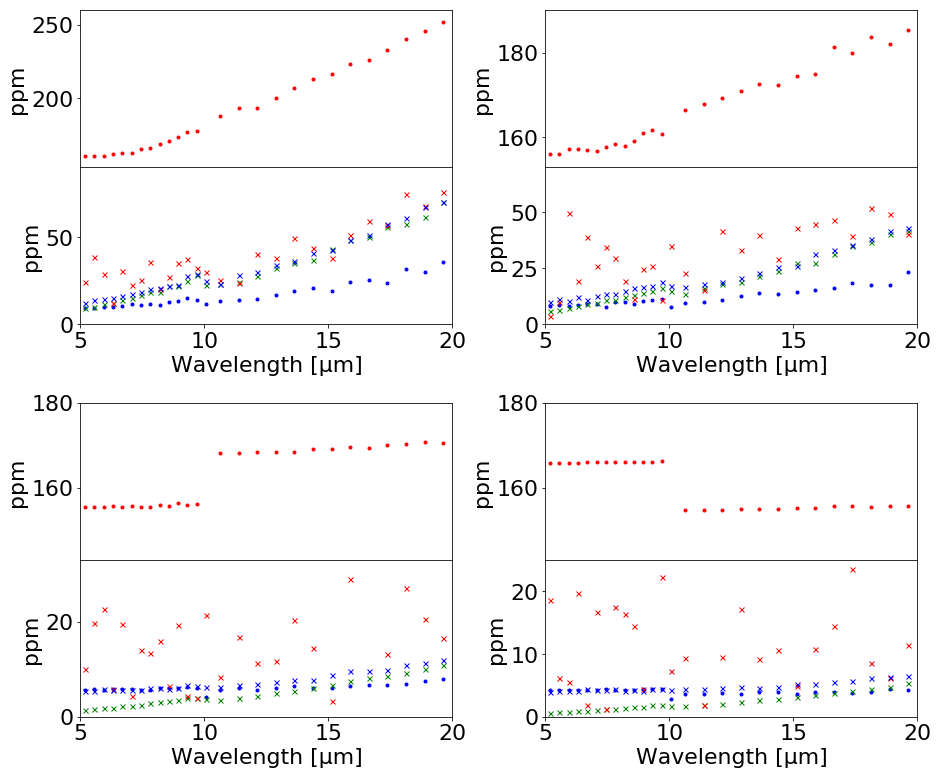

In [19]:
plt.figure(figsize=(15, 13))
gs = gridspec.GridSpec(9, 2)
plt.rcParams['font.size'] = 22
Evaluation(gs[0:2, 0], lamb_20, wog_eva_std_20, wog_rand_20, sci_eva_std_20, sci_rand_20, sub_eva_std_20, sub_rand_20, 0, 153, 260)
plt.xticks([])
Evaluation(gs[2:4, 0], lamb_20, wog_eva_std_20, wog_rand_20, sci_eva_std_20, sci_rand_20, sub_eva_std_20, sub_rand_20, 0, 0, 90)
Evaluation(gs[0:2, 1], lamb_20, wog_eva_std_20, wog_rand_20, sci_eva_std_20, sci_rand_20, sub_eva_std_20, sub_rand_20, 1, 153, 190)
plt.xticks([])
Evaluation(gs[2:4, 1], lamb_20, wog_eva_std_20, wog_rand_20, sci_eva_std_20, sci_rand_20, sub_eva_std_20, sub_rand_20, 1, 0, 70)
Evaluation(gs[5:7, 0], lamb_20, wog_eva_std_20, wog_rand_20, sci_eva_std_20, sci_rand_20, sub_eva_std_20, sub_rand_20, 2, 143, 180)
plt.xticks([])
Evaluation(gs[7:9, 0], lamb_20, wog_eva_std_20, wog_rand_20, sci_eva_std_20, sci_rand_20, sub_eva_std_20, sub_rand_20, 2, 0, 33)
Evaluation(gs[5:7, 1], lamb_20, wog_eva_std_20, wog_rand_20, sci_eva_std_20, sci_rand_20, sub_eva_std_20, sub_rand_20, 3, 143, 180)
plt.xticks([])
Evaluation(gs[7:9, 1], lamb_20, wog_eva_std_20, wog_rand_20, sci_eva_std_20, sci_rand_20, sub_eva_std_20, sub_rand_20, 3, 0, 25)
plt.subplots_adjust(hspace=0, wspace=0.25)
plt.show()

In [20]:
# 地球大気の吸収スペクトルに補正後のデータを載せた図を作成
def Spectrum(i, T, x, y, y_sys, y_err):
    sys_error = y[T]+y_sys[T]
    plt.subplot(i)
    plt.plot(x, y[T], c='r', linewidth = 2.0)
    plt.plot(x, sys_error, 'ro', c='g', markersize=5.0)
    plt.errorbar(x, sys_error, yerr=y_err[T], fmt='ro', markersize=0.0, ecolor='k')
    plt.xlabel('Wavelength [μm]')
    plt.ylabel('Transit depth [ppm]')
    plt.xlim(5, 20)

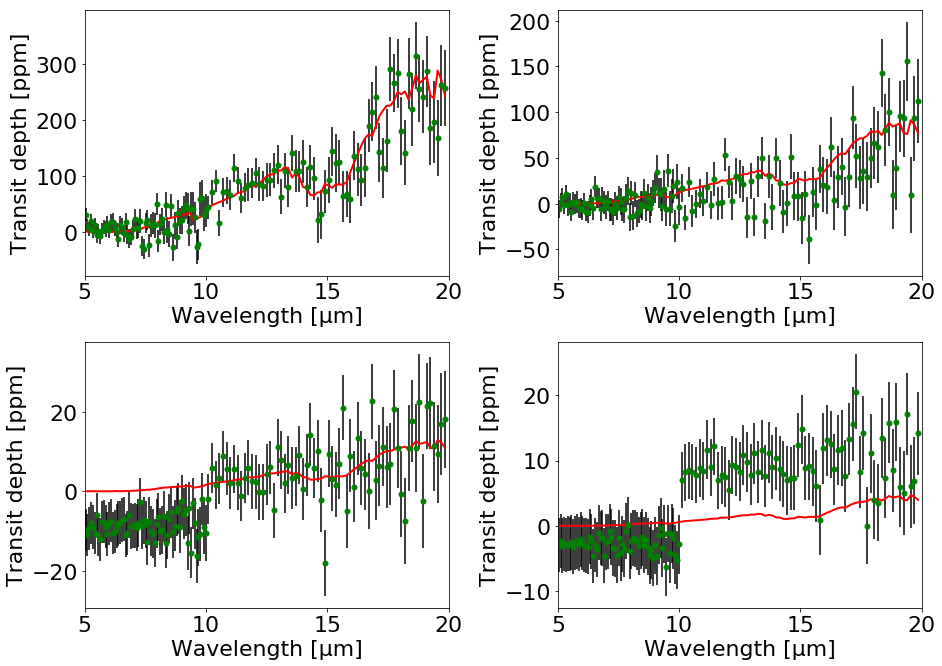

In [25]:
plt.figure(figsize=(15, 11))
plt.rcParams['font.size'] = 22
Spectrum(221, 0, lamb, spectrum, sub_eva[rd.choice(np.arange(100))], sub_sig[rd.choice(np.arange(100))])
Spectrum(222, 1, lamb, spectrum, sub_eva[rd.choice(np.arange(100))], sub_sig[rd.choice(np.arange(100))])
Spectrum(223, 2, lamb, spectrum, sub_eva[rd.choice(np.arange(100))], sub_sig[rd.choice(np.arange(100))])
Spectrum(224, 3, lamb, spectrum, sub_eva[rd.choice(np.arange(100))], sub_sig[rd.choice(np.arange(100))])
plt.subplots_adjust(hspace=0.25, wspace=0.3)
plt.show()

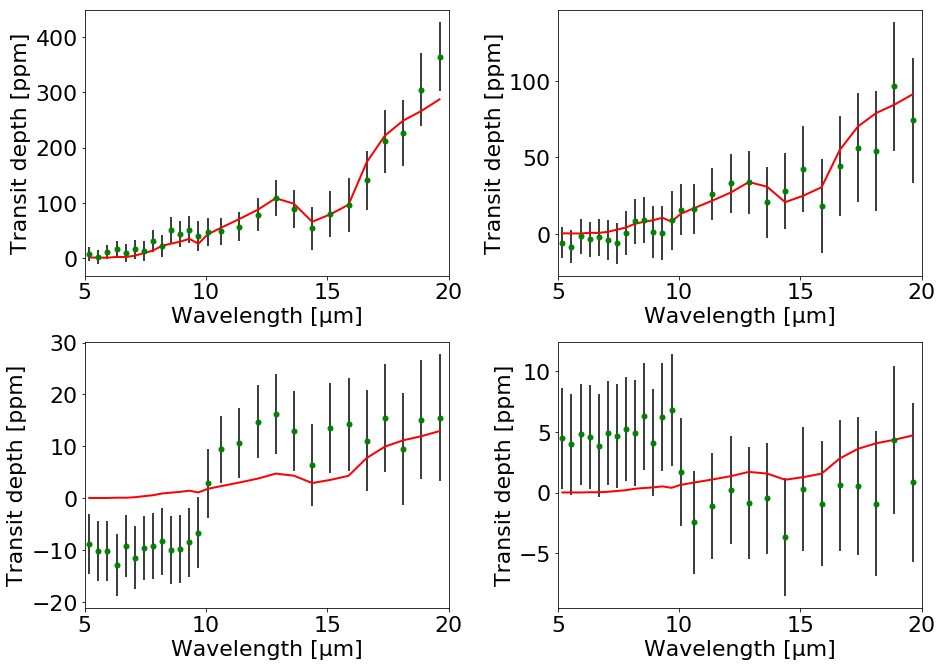

In [23]:
plt.figure(figsize=(15, 11))
plt.rcParams['font.size'] = 22
Spectrum(221, 0, lamb_20, spectrum_20, sub_eva_20[rd.choice(np.arange(100))], sub_sig_20[rd.choice(np.arange(100))])
Spectrum(222, 1, lamb_20, spectrum_20, sub_eva_20[rd.choice(np.arange(100))], sub_sig_20[rd.choice(np.arange(100))])
Spectrum(223, 2, lamb_20, spectrum_20, sub_eva_20[rd.choice(np.arange(100))], sub_sig_20[rd.choice(np.arange(100))])
Spectrum(224, 3, lamb_20, spectrum_20, sub_eva_20[rd.choice(np.arange(100))], sub_sig_20[rd.choice(np.arange(100))])
plt.subplots_adjust(hspace=0.25, wspace=0.3)
plt.show()